Using XFOIL: C:\Users\aravi\Downloads\XFOIL6.99\xfoil.exe
10/200 done | ok=4 | last file=naca4417_Re4000000_M0.20_a-4to12_da0.50.txt
20/200 done | ok=10 | last file=naca3217_Re500000_M0.25_a-4to12_da0.50.txt
30/200 done | ok=15 | last file=naca4217_Re500000_M0.25_a-4to12_da0.50.txt
40/200 done | ok=20 | last file=naca4415_Re1000000_M0.10_a-4to12_da0.50.txt
50/200 done | ok=25 | last file=naca2211_Re2000000_M0.05_a-4to12_da0.50.txt
60/200 done | ok=28 | last file=naca4217_Re2000000_M0.05_a-4to12_da0.50.txt
70/200 done | ok=33 | last file=naca4609_Re6000000_M0.05_a-4to12_da0.50.txt
80/200 done | ok=38 | last file=naca2412_Re200000_M0.25_a-4to12_da0.50.txt
90/200 done | ok=43 | last file=naca2409_Re2000000_M0.25_a-4to12_da0.50.txt
100/200 done | ok=47 | last file=naca1413_Re500000_M0.10_a-4to12_da0.50.txt
110/200 done | ok=53 | last file=naca4517_Re2000000_M0.05_a-4to12_da0.50.txt
120/200 done | ok=57 | last file=naca2617_Re6000000_M0.15_a-4to12_da0.50.txt
130/200 done | ok=60 | last file

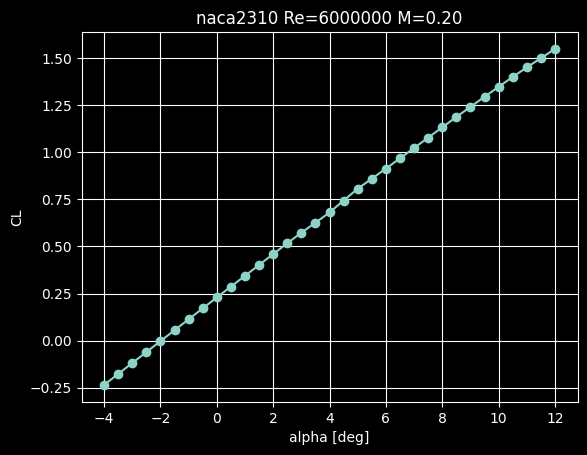

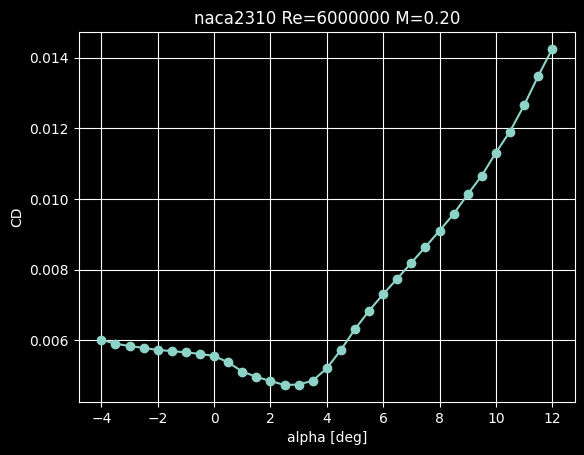

In [26]:
from pathlib import Path
import subprocess
import numpy as np
import pandas as pd
import sys
from shutil import which

# -----------------------------
# Project root (assumes notebook is in /notebooks)
# -----------------------------
ROOT = Path.cwd().resolve().parents[0]
sys.path.insert(0, str(ROOT))

from src.io_xfoil import parse_xfoil_polar_txt  # noqa


# -----------------------------
# Auto-find XFOIL (no manual path needed)
# -----------------------------
def find_xfoil_exe(project_root: Path) -> Path:
    """
    Try to find xfoil.exe automatically on Windows.
    Search order:
      1) <repo>/tools/xfoil/xfoil.exe
      2) PATH (shutil.which)
      3) common locations (Downloads/Desktop/Documents, C:/XFOIL*, Program Files)
    """
    # 1) Repo-local (best for teams)
    candidate = project_root / "tools" / "xfoil" / "xfoil.exe"
    if candidate.exists():
        return candidate

    # 2) PATH
    p = which("xfoil") or which("xfoil.exe")
    if p:
        return Path(p)

    # 3) Common locations (quick search)
    home = Path.home()
    common_roots = [
        home / "Downloads",
        home / "Desktop",
        home / "Documents",
        Path("C:/XFOIL"),
        Path("C:/XFOIL6.99"),
        Path("C:/Program Files"),
        Path("C:/Program Files (x86)"),
    ]

    patterns = [
        "**/xfoil.exe",
        "**/XFOIL*/xfoil.exe",
        "**/xfoil*/xfoil.exe",
    ]

    for root in common_roots:
        if root.exists():
            for pat in patterns:
                hits = list(root.glob(pat))
                if hits:
                    return hits[0]

    raise FileNotFoundError(
        "Konnte xfoil.exe nicht automatisch finden.\n"
        "Option A (empfohlen fürs Team): Lege xfoil.exe in <repo>/tools/xfoil/xfoil.exe\n"
        "Option B: Installiere XFOIL und füge den Ordner mit xfoil.exe zur PATH-Umgebungsvariable hinzu."
    )


XFOIL_EXE = find_xfoil_exe(ROOT)
print("Using XFOIL:", XFOIL_EXE)

# -----------------------------
# Output dirs
# -----------------------------
RAW_DIR = ROOT / "data" / "raw" / "polars"
RAW_DIR.mkdir(parents=True, exist_ok=True)

PROCESSED_DIR = ROOT / "data" / "processed"
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)


# -----------------------------
# XFOIL runner with timeout (prevents hanging forever)
# -----------------------------
def run_xfoil_polar(
    naca_in: int,
    re_in: float,
    mach_in: float,
    alpha_start: float,
    alpha_end: float,
    alpha_step: float,
    polar_path: Path,
    iters: int = 250,
    timeout_sec: int = 25,
    retries: int = 1,
) -> tuple[bool, str]:
    """
    Runs XFOIL in batch mode and writes polar_path.
    If XFOIL hangs, timeout stops it. Optionally retries a small number of times.
    Returns (ok, log_text).
    """
    polar_path.parent.mkdir(parents=True, exist_ok=True)
    polar_rel = polar_path.relative_to(ROOT).as_posix()

    script = f"""\
NACA {naca_in}
PANE
OPER
ITER {iters}
VISC {re_in:.0f}
MACH {mach_in:.3f}
PACC
{polar_rel}

ASEQ {alpha_start:.3f} {alpha_end:.3f} {alpha_step:.3f}
PACC
QUIT
"""

    last_log = ""
    for attempt in range(retries + 1):
        try:
            res = subprocess.run(
                [str(XFOIL_EXE)],
                input=script,
                text=True,
                cwd=str(ROOT),
                capture_output=True,
                timeout=timeout_sec,
            )

            last_log = (res.stdout or "") + "\n" + (res.stderr or "")
            ok = (res.returncode == 0) and polar_path.exists() and polar_path.stat().st_size > 200
            if ok:
                return True, last_log

            # if failed, try again with slightly higher iters
            iters = int(iters * 1.2)

        except subprocess.TimeoutExpired:
            last_log = f"TIMEOUT after {timeout_sec}s (attempt {attempt+1}/{retries+1}). XFOIL killed."
            timeout_sec = int(timeout_sec * 1.5)
            iters = int(iters * 1.2)

    return False, last_log


# -----------------------------
# Sampling NACA 4-digit (exclude 13xx)
# -----------------------------
def sample_naca4(rng_gen: np.random.Generator) -> int:
    # m: 0..4 (% camber), p: 2..6 (0.2..0.6c), t: 8..18 (% thickness)
    # exclude 13xx => m=1 and p=3
    while True:
        m = int(rng_gen.integers(0, 5))
        p = int(rng_gen.integers(2, 7))
        t = int(rng_gen.integers(8, 19))
        if not (m == 1 and p == 3):
            return int(f"{m}{p}{t:02d}")


# -----------------------------
# Robust ranges (good for XFOIL)
# -----------------------------
ALPHA_START, ALPHA_END, ALPHA_STEP = -4.0, 12.0, 0.5
RE_VALUES = [2e5, 5e5, 1e6, 2e6, 4e6, 6e6]
MACH_VALUES = [0.05, 0.10, 0.15, 0.20, 0.25]
NCRIT_CONST = 9.0  # stored as column; not actively set in XFOIL here

EXPECTED_ALPHAS = np.round(np.arange(ALPHA_START, ALPHA_END + 1e-9, ALPHA_STEP), 6)

# number of polars (sentences)
N_SETS = 200  # later: 10_000


# -----------------------------
# Generate dataset
# -----------------------------
rng_gen = np.random.default_rng(42)

all_rows = []
run_index = []

for i in range(1, N_SETS + 1):
    naca_code = sample_naca4(rng_gen)
    re_val = float(rng_gen.choice(RE_VALUES))
    mach = float(rng_gen.choice(MACH_VALUES))

    fname = (
        f"naca{naca_code}_Re{re_val:.0f}_M{mach:.2f}"
        f"_a{ALPHA_START:.0f}to{ALPHA_END:.0f}_da{ALPHA_STEP:.2f}.txt"
    )
    polar_out = RAW_DIR / fname

    # skip if already exists
    if polar_out.exists() and polar_out.stat().st_size > 200:
        ok_run, xfoil_log = True, "SKIP (exists)"
    else:
        ok_run, xfoil_log = run_xfoil_polar(
            naca_in=naca_code,
            re_in=re_val,
            mach_in=mach,
            alpha_start=ALPHA_START,
            alpha_end=ALPHA_END,
            alpha_step=ALPHA_STEP,
            polar_path=polar_out,
            iters=250,
            timeout_sec=25,
            retries=1,
        )

    if ok_run:
        try:
            dfp = parse_xfoil_polar_txt(polar_out)

            # ensure metadata columns exist
            if "naca" not in dfp.columns:
                dfp["naca"] = int(naca_code)
            if "Ncrit" not in dfp.columns:
                dfp["Ncrit"] = float(NCRIT_CONST)

            # strict alpha completeness check
            got = np.round(np.sort(dfp["alpha_deg"].to_numpy()), 6)
            full_alpha = np.array_equal(got, EXPECTED_ALPHAS)

            if full_alpha:
                all_rows.append(dfp[["naca", "Re", "Mach", "Ncrit", "alpha_deg", "CL", "CD"]].copy())
                run_index.append(
                    {
                        "ok": True,
                        "naca": naca_code,
                        "Re": re_val,
                        "Mach": mach,
                        "Ncrit": NCRIT_CONST,
                        "polar_file": polar_out.relative_to(ROOT).as_posix(),
                        "n_rows": len(dfp),
                    }
                )
            else:
                run_index.append(
                    {
                        "ok": False,
                        "reason": "missing_alpha_points",
                        "naca": naca_code,
                        "Re": re_val,
                        "Mach": mach,
                        "Ncrit": NCRIT_CONST,
                        "polar_file": polar_out.relative_to(ROOT).as_posix(),
                        "n_rows": len(dfp),
                        "got_min_alpha": float(got.min()) if len(got) else None,
                        "got_max_alpha": float(got.max()) if len(got) else None,
                    }
                )

        except Exception as e:
            run_index.append(
                {
                    "ok": False,
                    "reason": f"parse_failed: {e}",
                    "naca": naca_code,
                    "Re": re_val,
                    "Mach": mach,
                    "Ncrit": NCRIT_CONST,
                    "polar_file": polar_out.relative_to(ROOT).as_posix(),
                    "n_rows": 0,
                }
            )
    else:
        run_index.append(
            {
                "ok": False,
                "reason": "xfoil_failed_or_timeout",
                "naca": naca_code,
                "Re": re_val,
                "Mach": mach,
                "Ncrit": NCRIT_CONST,
                "polar_file": polar_out.relative_to(ROOT).as_posix(),
                "n_rows": 0,
                "log_snippet": xfoil_log[:200],
            }
        )

    if i % 10 == 0:
        n_ok = sum(1 for r in run_index if r.get("ok"))
        print(f"{i}/{N_SETS} done | ok={n_ok} | last file={polar_out.name}")


# -----------------------------
# Save outputs
# -----------------------------
dataset_csv = PROCESSED_DIR / "xfoil_dataset_rows.csv"
runs_csv = PROCESSED_DIR / "xfoil_runs_index.csv"

df_all = pd.concat(all_rows, ignore_index=True) if all_rows else pd.DataFrame(
    columns=["naca", "Re", "Mach", "Ncrit", "alpha_deg", "CL", "CD"]
)

df_all.to_csv(dataset_csv, index=False)
pd.DataFrame(run_index).to_csv(runs_csv, index=False)

print("WROTE:", dataset_csv, "rows:", len(df_all))
print("WROTE:", runs_csv, "rows:", len(run_index))


# -----------------------------
# Quick sanity plot (optional)
# -----------------------------
import matplotlib.pyplot as plt

if len(df_all):
    ex = df_all.iloc[0]
    n0, r0, m0 = int(ex["naca"]), float(ex["Re"]), float(ex["Mach"])
    sub = df_all[(df_all["naca"] == n0) & (df_all["Re"] == r0) & (df_all["Mach"] == m0)].sort_values("alpha_deg")

    plt.figure()
    plt.plot(sub["alpha_deg"], sub["CL"], marker="o")
    plt.xlabel("alpha [deg]")
    plt.ylabel("CL")
    plt.grid(True)
    plt.title(f"naca{n0} Re={r0:.0f} M={m0:.2f}")
    plt.show()

    plt.figure()
    plt.plot(sub["alpha_deg"], sub["CD"], marker="o")
    plt.xlabel("alpha [deg]")
    plt.ylabel("CD")
    plt.grid(True)
    plt.title(f"naca{n0} Re={r0:.0f} M={m0:.2f}")
    plt.show()
